<a href="https://colab.research.google.com/github/NsiriRoua/Computer-Vision/blob/main/Canny_Edge_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Steps :**

-   Noise reduction using Gaussian filter 

 
-  Gradient calculation along the horizontal and vertical axis 
 
-  Non-Maximum suppression of false edges 
 
-  Double thresholding for segregating strong and weak edges 
 
-   Edge tracking by hysteresis

# **Step 1 : Noise Reduction**

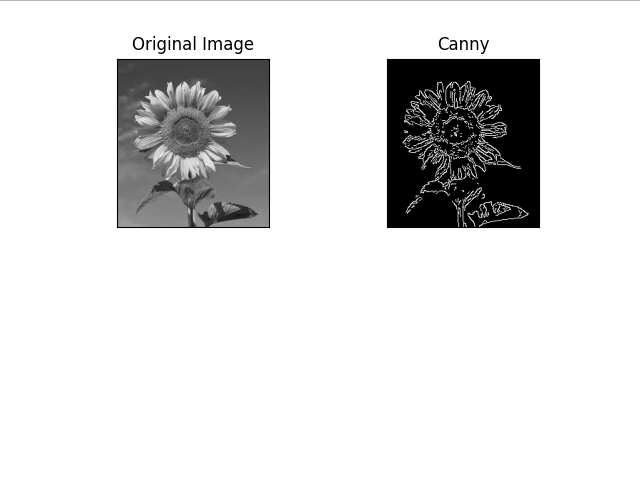

Let's generate the Gaussian 5x5 kernel

It uses a Gaussian filter for the removal of noise from the image, it is because this noise can be assumed as edges due to sudden intensity change by the edge detector. The sum of the elements in the Gaussian kernel is 1, so, the kernel should be normalized before applying as convolution to the image. In this tutorial, we will use a kernel of size 5 X 5 and sigma = 1.4, which will blur the image and remove the noise from it .

The equation for Gaussian filter kernel is :

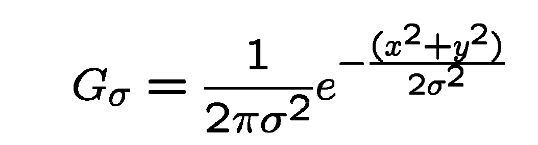

**Step 2 : Gradient Calculation**

When the image is smoothed, the derivatives Ix and Iy are calculated w.r.t x and y axis. It can be implemented by using the Sobel-Feldman kernels convolution with image as given :


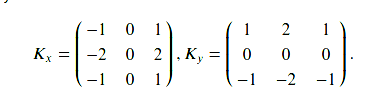

after applying these kernel we can use the gradient magnitudes and the angle to further process this step .

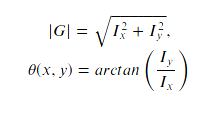

**Step 3 :  Non-Maximum Suppression**

This step aims at reducing the duplicate merging pixels along the edges to make them uneven. 

For each pixel find two neighbors in the positive and negative gradient directions, supposing that each neighbor occupies the angle of pi /4, and 0 is the direction straight to the right. If the magnitude of the current pixel is greater than the magnitude of the neighbors, nothing changes, otherwise, the magnitude of the current pixel is set to zero.


**Explanation** :

The principle is simple: the algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.


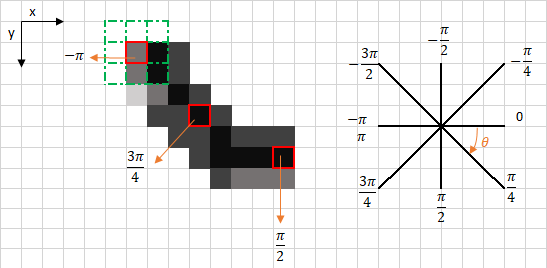


The upper left corner red box present on the above image, represents an intensity pixel of the Gradient Intensity matrix being processed. The corresponding edge direction is represented by the orange arrow with an angle of -pi radians (+/-180 degrees).

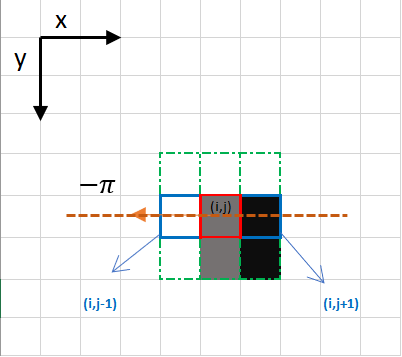

The edge direction is the orange dotted line (horizontal from left to right). The purpose of the algorithm is to check if the pixels on the same direction are more or less intense than the ones being processed. In the example above, the pixel (i, j) is being processed, and the pixels on the same direction are highlighted in blue (i, j-1) and (i, j+1). If one those two pixels are more intense than the one being processed, then only the more intense one is kept. Pixel (i, j-1) seems to be more intense, because it is white (value of 255). Hence, the intensity value of the current pixel (i, j) is set to 0. If there are no pixels in the edge direction having more intense values, then the value of the current pixel is kept.

Let’s now focus on another example:

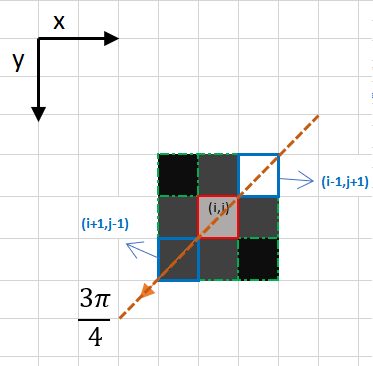

In this case the direction is the orange dotted diagonal line. Therefore, the most intense pixel in this direction is the pixel (i-1, j+1).
Let’s sum this up. Each pixel has 2 main criteria (edge direction in radians, and pixel intensity (between 0–255)). Based on these inputs the non-max-suppression steps are:

- Create a matrix initialized to 0 of the same size of the original gradient intensity matrix;

- Identify the edge direction based on the angle value from the angle matrix;
Check if the pixel in the same direction has a higher intensity than the pixel that is currently processed;
- Return the image processed with the non-max suppression algorithm.


**step 4 : Double Thresholding**

The double threshold step aims at identifying 3 kinds of pixels: strong, weak, and non-relevant:

- **Strong pixels** are pixels that have an intensity so high that we are sure they contribute to the final edge.
- **Weak pixels** are pixels that have an intensity value that is not enough to be considered as strong ones, but yet not small enough to be considered as non-relevant for the edge detection.
- **Other pixels** are considered as non-relevant for the edge.



Now you can see what the double thresholds holds for:

- High threshold is used to identify the strong pixels (intensity higher than the high threshold).

-  Low threshold is used to identify the non-relevant pixels (intensity lower than the low threshold)

- All pixels having intensity between both thresholds are flagged as weak and the Hysteresis mechanism (next step) will help us identify the ones that could be considered as strong and the ones that are considered as non-relevant.


**Step 5 : Edge Tracking by Hysteresis**

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones, if and only if at least one of the pixels around the one being processed is a strong one, as described below :


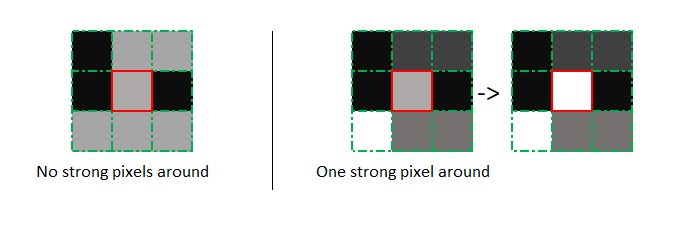

In [8]:
import numpy as np 
import os
import cv2
import matplotlib.pyplot as plt


In [7]:
def Canny_detector(img, weak_th = None, strong_th = None):
     
    #We need  to convert  of image to grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
      
    # 1st step : Noise reduction 
    img = cv2.GaussianBlur(img, (5, 5), 1.4)
      
    # 2nd step : Calculating the gradients
    gx = cv2.Sobel(np.float32(img), cv2.CV_64F, 1, 0, 3)
    gy = cv2.Sobel(np.float32(img), cv2.CV_64F, 0, 1, 3)
     
    #Suite step 2 Conversion of Cartesian coordinates to polar
    mag, ang = cv2.cartToPolar(gx, gy, angleInDegrees = True)
      
    # setting the minimum and maximum thresholds
    # for double thresholding
    mag_max = np.max(mag)
    if not weak_th:weak_th = mag_max * 0.1
    if not strong_th:strong_th = mag_max * 0.5
     
    # getting the dimensions of the input image 
    height, width = img.shape
      
    # Looping through every pixel of the grayscale
    # image
    for i_x in range(width):
        for i_y in range(height):
              
            grad_ang = ang[i_y, i_x]
            grad_ang = abs(grad_ang-180) if abs(grad_ang)>180 else abs(grad_ang)
              
            # selecting the neighbours of the target pixel
            # according to the gradient direction
            # In the x axis direction
            if grad_ang<= 22.5:
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
             
            # top right (diagonal-1) direction
            elif grad_ang>22.5 and grad_ang<=(22.5 + 45):
                neighb_1_x, neighb_1_y = i_x-1, i_y-1
                neighb_2_x, neighb_2_y = i_x + 1, i_y + 1
             
            # In y-axis direction
            elif grad_ang>(22.5 + 45) and grad_ang<=(22.5 + 90):
                neighb_1_x, neighb_1_y = i_x, i_y-1
                neighb_2_x, neighb_2_y = i_x, i_y + 1
             
            # top left (diagonal-2) direction
            elif grad_ang>(22.5 + 90) and grad_ang<=(22.5 + 135):
                neighb_1_x, neighb_1_y = i_x-1, i_y + 1
                neighb_2_x, neighb_2_y = i_x + 1, i_y-1
             
            # Now it restarts the cycle
            elif grad_ang>(22.5 + 135) and grad_ang<=(22.5 + 180):
                neighb_1_x, neighb_1_y = i_x-1, i_y
                neighb_2_x, neighb_2_y = i_x + 1, i_y
              
            # Non-maximum suppression step
            if width>neighb_1_x>= 0 and height>neighb_1_y>= 0:
                if mag[i_y, i_x]<mag[neighb_1_y, neighb_1_x]:
                    mag[i_y, i_x]= 0
                    continue
  
            if width>neighb_2_x>= 0 and height>neighb_2_y>= 0:
                if mag[i_y, i_x]<mag[neighb_2_y, neighb_2_x]:
                    mag[i_y, i_x]= 0
  
    weak_ids = np.zeros_like(img)
    strong_ids = np.zeros_like(img)             
    ids = np.zeros_like(img)
      
    # double thresholding step
    for i_x in range(width):
        for i_y in range(height):
             
            grad_mag = mag[i_y, i_x]
             
            if grad_mag<weak_th:
                mag[i_y, i_x]= 0
            elif strong_th>grad_mag>= weak_th:
                ids[i_y, i_x]= 1
            else:
                ids[i_y, i_x]= 2
      
      
    # finally returning the magnitude of
    # gradients of edges
    return mag

In [9]:
#Let's read the image
img=cv2.imread('/content/sample_data/tour_eiffel.jpg')

In [10]:
#Let's call the function
canny_img=Canny_detector(img)

<Figure size 432x288 with 0 Axes>

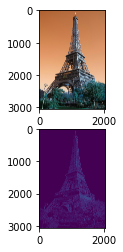

In [14]:
#Let's display the figure
#Initialize the figure
plt.figure()
#The plots
f,plots=plt.subplots(2,1)
plots[0].imshow(img)
plots[1].imshow(canny_img)